# Gaussian Process Regression: Structure Discovery
**Author:** Harshad Dahake

**Context:** Approximate Inference Coursework (Gatsby Unit)

### Description
A PyTorch-based investigation into **Structure Discovery** using Gaussian Processes (GPs) on real-world time-series data (Mauna Loa CO2).

**Key Features:**
* **Compositional Kernel Search:** Modeling complex signals by composing elementary kernels:
    * *Linear Kernel* (Long-term Trend)
    * *Periodic Kernel* (Seasonality)
    * *Squared-Exponential Kernel* (Short-term deviations)
* **Model Selection:** Using the **Log Marginal Likelihood** to optimize hyperparameters and select the best structural hypothesis.
* **Extrapolation:** Demonstrating the superior generalization of structure-aware models vs. standard RBF baselines.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.distributions as dist

In [2]:
with open("co2.txt") as f:
    data = pd.read_csv(f, skiprows=56, header=1, sep=r'\s+')

data.columns = list(data.columns[1:]) + ['extra']
data = data.iloc[:, :-1]

# data.head(5)

In [3]:
## (a): Bayesian Linear Regression

In [4]:
# f(t) = at + b + eps(t)

# prior on a: N(0,10^2); a_mean = 0, a_sd = 10
# prior on b: N(360,100^2); b_mean = 360, b_sd = 100
# noise (eps): N(0,1); eps_mean = 0, eps_sd = 1

a_mean = 0; a_sd = 10
b_mean = 360; b_sd = 100
eps_mean = 0; eps_sd = 1

# a = dist.Normal(a_mean, a_sd)
# b = dist.Normal(b_mean, b_sd)
# eps = dist.Normal(eps_mean, eps_sd)

In [5]:
X = np.array(data["decimal"])

# Given the prior on b (b_mean, esp.), the bias term (b) must carry the bulk of the expectation(.), and thus we will shift and scale (normalise) t ("decimal" year variable)
# X_sd = np.std(X)
# X_mean = np.mean(X)
# X_scaled = (X - X_mean) / X_sd
# X = X_scaled

X = X.reshape(1,-1)
N = X.shape[1]

X = np.vstack([X, np.ones(N)])

print(X.shape)

(2, 500)


In [6]:
Y = np.array(data["average"])
Y = Y.reshape(1,-1)
Y.shape

(1, 500)

In [7]:
C = np.array([[a_sd**2,0],[0,b_sd**2]])
C_inv = np.linalg.inv(C)

In [8]:
a_prec_posterior = (1/eps_sd**2) * (X @ X.T) + C_inv
print(f"precision matrix:\n {a_prec_posterior}")

a_cov_posterior = np.linalg.inv(a_prec_posterior)
print(f"\ncovariance matrix:\n {a_cov_posterior}")

del a_prec_posterior

precision matrix:
 [[2.00173935e+09 1.00041667e+06]
 [1.00041667e+06 5.00000100e+02]]

covariance matrix:
 [[ 1.37479698e-05 -2.75073908e-02]
 [-2.75073908e-02  5.50396935e+01]]


In [9]:
# f_mean = b_mean * np.ones(N); f_mean = f_mean.reshape(1,-1)
a_mean_posterior = (1/eps_sd**2) * (a_cov_posterior @ (X @ (Y).T)) # -f_mean

In [10]:
a_mean_posterior

array([[ 1.81941835e+00],
       [-3.26813239e+03]])

In [11]:
a_cov_posterior

array([[ 1.37479698e-05, -2.75073908e-02],
       [-2.75073908e-02,  5.50396935e+01]])

In [12]:
a_map = a_mean_posterior[0]; b_map = a_mean_posterior[1]
print(f"a_MAP: {np.round(a_map,3).item()} and b_MAP: {np.round(b_map,3).item()}")

a_MAP: 1.819 and b_MAP: -3268.132


In [13]:
## (b): Residuals and Observations 

In [14]:
residuals = Y - ( a_map*(X[0,:]) + b_map )

In [15]:
np.mean(residuals).item()

-0.0006536237972486561

In [16]:
np.var(residuals).item()

7.185510988169439

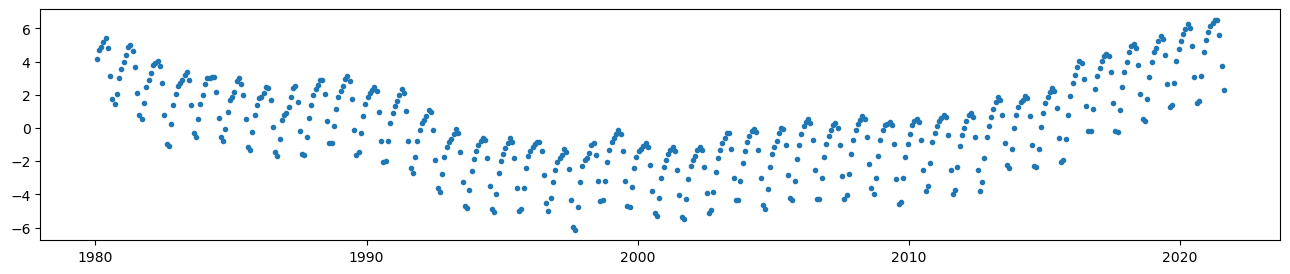

In [17]:
plt.figure(figsize=(16,3))
plt.scatter(X[0,:], residuals, marker=".")
plt.show()

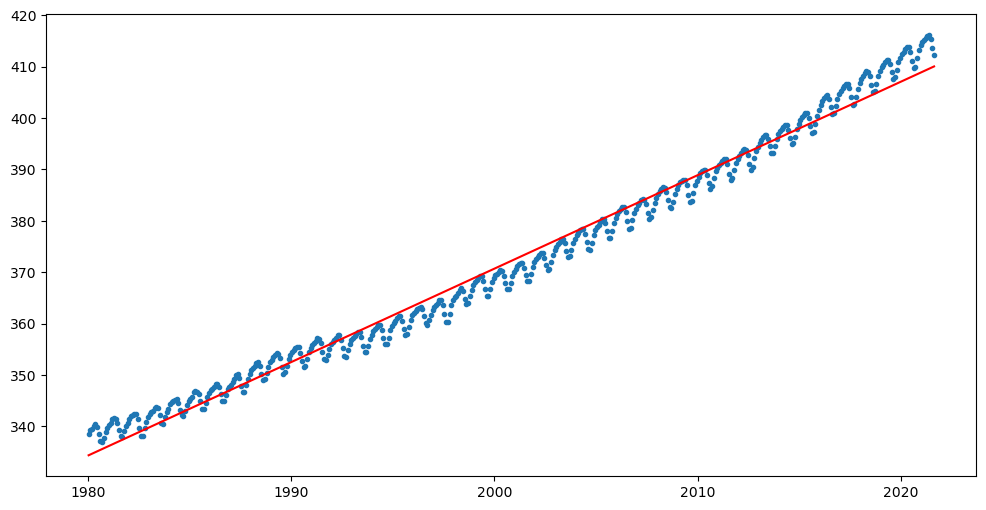

In [18]:
y_preds =  a_map*(X[0,:]) + b_map 

plt.figure(figsize=(12,6))
plt.scatter(X[0,:], Y.reshape(-1), marker=".")
plt.plot(X[0,:], a_map*(X[0,:]) + b_map, c="red")
plt.show()

In [19]:
print(f"mean: {np.mean(residuals)} and sd: {np.std(residuals)}")

mean: -0.0006536237972486561 and sd: 2.6805803454045987


In [20]:
# Observations

# Assumption  1: Noise prior mean ~ 0 with variance ~ 1
# Data point  1: Current model residual mean ~ 0 with variance ~ 7.17 / std. dev. ~ 2.68
# Observation 1: While mean is close to 0 (as expected), the residual variance is higher.

# Data point  2: Time-variant residuals (higher on the extremes of timeline, systematically lower in the middle (years))
# Observation 2: This suggests a polynomial / exponential dependency on time that is missed by the linear model.

## Conclusion 1: Linear model might NOT be sufficient. We need to add more components to the model. The GP Kernel (perhaps, the squared exponential) can help model this part of the residuals.

# Assumption  2: I.I.D. Noise residual
# Data point  2: Current model residual is cyclic
# Observation 2: Residual does NOT satisfy the I.I.D. assumption. There is autocorrelation among the current model residuals.

## Conclusion 2: There is likely a seasonal trend with a yearly period. The GP Kernel (perhaps, the sinusoidal) can help model this part of the residuals.

In [21]:
theta, tau, sigma, phi, eta, zeta = (1,1,1,1,1,1) # trial values to test function

def kernel_function(s, t, theta, tau, sigma, phi, eta, zeta):
    delta = 1.0 if s == t else 0.0
    # print(f"delta: {delta}")
    diff = s - t
    k = theta**2 * ( np.exp( -(2 * (np.sin( np.pi*diff/tau ))**2 )/(sigma**2)) + ( phi**2 * (np.exp( -(diff**2)/(2 * eta**2) ))) ) + zeta**2 * delta
    return float(k)


In [22]:
def gaussian_process_sample(x, theta, tau, sigma, phi, eta, zeta, kernel=kernel_function):
    '''
    x : input points (vector: (1,n)) in domain to evaluate kernel
    kernel : covariance kernel function

    Process:
    1) Take kernel function and evaluate it on the input vector x: get Kxx for all pairs
    2) Define a Multi-variate Normal distribution: P(y|x,[params]) ~ N(0,Kxx)
    '''

    n = x.shape[0]
    # print(f"n = {n}")

    Kxx = torch.ones((n,n))

    for i in range(n):
        for j in range(n):
            kernel_eval = kernel(x[i],x[j], theta, tau, sigma, phi, eta, zeta)
            # print(f"kernel evaluated at {x[i].item(), x[j].item()} = {kernel_eval}")
            Kxx[i,j] = kernel_eval
    
    Mx = torch.zeros(n)
    
    y = dist.MultivariateNormal(Mx,Kxx)

    f = y.sample()

    return f # change back to "return f, y" for testing multiple samples, if needed

/var/folders/7q/g76vv1gn7qs4j7dfwj8sqpyh0000gn/T/ipykernel_43543/3188288750.py:7: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  k = theta**2 * ( np.exp( -(2 * (np.sin( np.pi*diff/tau ))**2 )/(sigma**2)) + ( phi**2 * (np.exp( -(diff**2)/(2 * eta**2) ))) ) + zeta**2 * delta


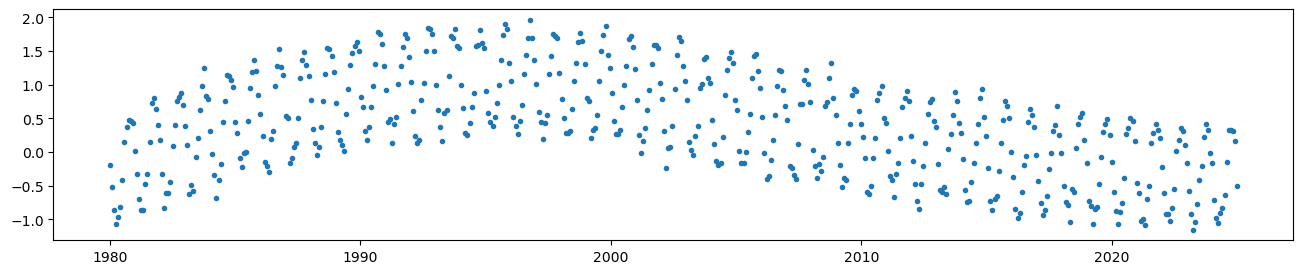

In [23]:
## TESTING SELECTED HYPERPARAMETERS (VISUALLY)

theta, tau, sigma, phi, eta, zeta = (8.0,1.0,15.0,1.0,30.0,0.1)

points = np.linspace(1980, 2025, 12*(2025-1980))
x1 = torch.tensor(points)

y = gaussian_process_sample(x1, theta, tau, sigma, phi, eta, zeta)

plt.figure(figsize=(16,3))
plt.scatter(x1, y, marker=".")
plt.show()

In [24]:
# for i in range(10):
#     y_sample = f.sample()
#     plt.figure(figsize=(16,3))
#     plt.scatter(x1,y_sample, marker=".")
#     plt.show()

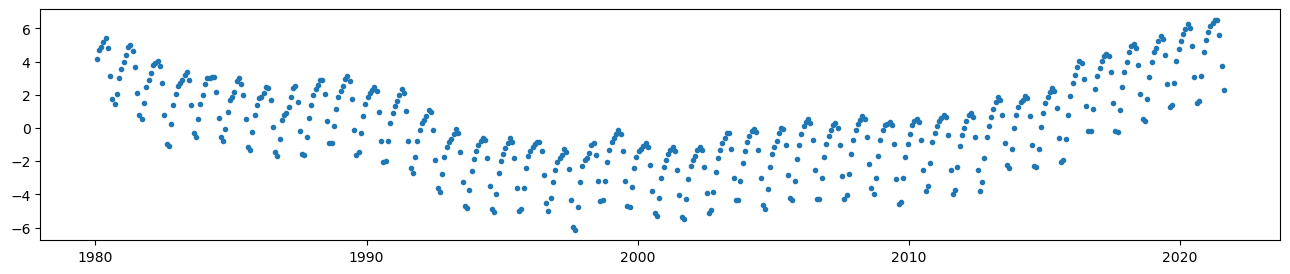

In [25]:
## PLOT RESIDUALS AGAIN
plt.figure(figsize=(16,3))
plt.scatter(X[0,:], residuals, marker=".")
plt.show()

In [26]:
## DEFINE POSTERIOR (ANALYTICAL FOR GP)

theta, tau, sigma, phi, eta, zeta = (8.0,1.0,15.0,1.0,30.0,0.1)

points = np.linspace(1980, 2025, 12*(2025-1980))
x1 = torch.tensor(points)

# y = gaussian_process_sample(x1, theta, tau, sigma, phi, eta, zeta)

def gp_posterior(x_train, y_train, x_test, theta=8.0, tau=1.0, sigma=15.0, phi=1.0, eta=30.0, zeta=0.1, kernel=kernel_function):
    
    # Force Y to be (1, N) so Y.T becomes (N, 1)
    Y = y_train.reshape(1, -1) # Y = y_train

    # Kernel function evaluations for train and test data points

    # K(X,X)
    n_train = x_train.shape[0]
    K_XX = torch.ones((n_train,n_train))
    for i in range(n_train):
        for j in range(n_train):
            kernel_eval = kernel(x_train[i],x_train[j], theta, tau, sigma, phi, eta, zeta)
            K_XX[i,j] = kernel_eval
    
    # Calculate K_XX_inv (inverse)
    K_XX_stable = K_XX + 1e-4 * torch.eye(n_train)
    K_XX_cho = torch.linalg.cholesky(K_XX_stable)
    #### K_XX_inv = torch.cholesky_inverse(K_XX_cho)
    
    # K(.,.)
    n_test = x_test.shape[0]
    K_xx = torch.ones((n_test,n_test))
    for i in range(n_test):
        for j in range(n_test):
            kernel_eval = kernel(x_test[i],x_test[j], theta, tau, sigma, phi, eta, zeta) # zeta = 0.0 for "noise" in test points? !!! <- DECIDE WHETHER TO CHANGE THIS !!!
            K_xx[i,j] = kernel_eval
    
    # K(.,X)
    K_xX = torch.ones((n_test,n_train))
    for i in range(n_test):
        for j in range(n_train):
            kernel_eval = kernel(x_test[i],x_train[j], theta, tau, sigma, phi, eta, zeta) # zeta = 0.0 for "noise" in test points? !!! <- should be fine here as x_train != x_test
            K_xX[i,j] = kernel_eval
    

    # 2. Solve for Mean (Analytic Posterior Mean)
    # Grouping solving avoids explicit inversion
    alpha = torch.linalg.solve_triangular(K_XX_cho, Y.T, upper=False)
    alpha = torch.linalg.solve_triangular(K_XX_cho.T, alpha, upper=True)
    mean_vec = (K_xX @ alpha).flatten()

    # 3. Solve for Covariance (Analytic Posterior Covariance)
    # This is the stable way to compute K_xx - K_xX @ K_XX_inv @ K_xX.T
    v = torch.linalg.solve_triangular(K_XX_cho, K_xX.T, upper=False)
    cov_matrix = K_xx - (v.T @ v)

    # 4. Final cleaning and Posterior Cholesky
    cov_matrix = 0.5 * (cov_matrix + cov_matrix.T)
    cov_matrix_stable = cov_matrix + 1e-4 * torch.eye(n_test)
    # print(f"cov_matrix_stable:\n{cov_matrix_stable}")

    L_post = torch.linalg.cholesky(cov_matrix_stable)
    

    ##### define sampler
    s = dist.MultivariateNormal(loc=mean_vec, scale_tril=L_post) # cov_matrix_cho # <- Using "scale_tril" argument that takes the Cholesky Decomposition (L) to avoid numerical instability

    return s

In [27]:
## train model and get posterior sampler
x_train = X[0,:]
y_train = torch.tensor(residuals)
test_start_year = 0
test_end_year = 15
# x_test = x_train[int(12*test_start_year):int(12*test_end_year)] + 1e-5
x_test = x_train + 1e-7

f = gp_posterior(x_train, y_train, x_test, theta=4.0, tau=1.0, sigma=2.0, phi=3.5, eta=5.0, zeta=0.1)

# print(f"Mean shape: {f.loc.shape}")

# theta, tau, sigma, phi, eta, zeta = (8.0,1.0,15.0,1.0,30.0,0.1)

/var/folders/7q/g76vv1gn7qs4j7dfwj8sqpyh0000gn/T/ipykernel_43543/2544844474.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_test, y, marker=".", cmap='red')


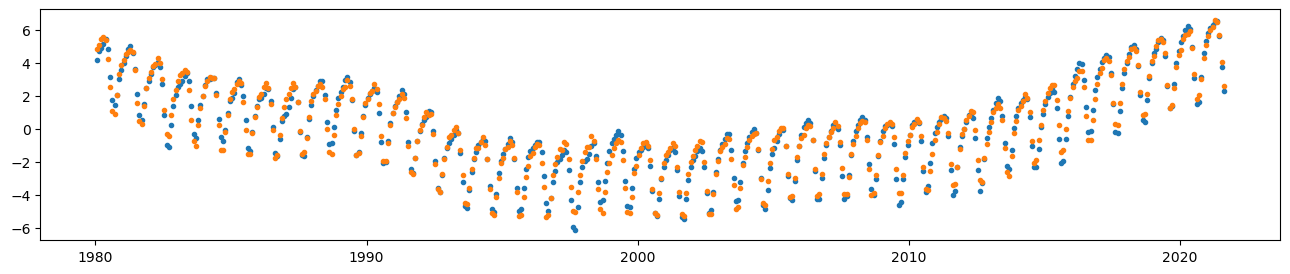

In [28]:
## PLOT FUNCTION AND RESIDUALS DATA TO EVALUATE FIT VISUALLY
y = f.sample()

plt.figure(figsize=(16,3))
plt.scatter(x_train, residuals, marker=".")
plt.scatter(x_test, y, marker=".", cmap='red')
plt.show()

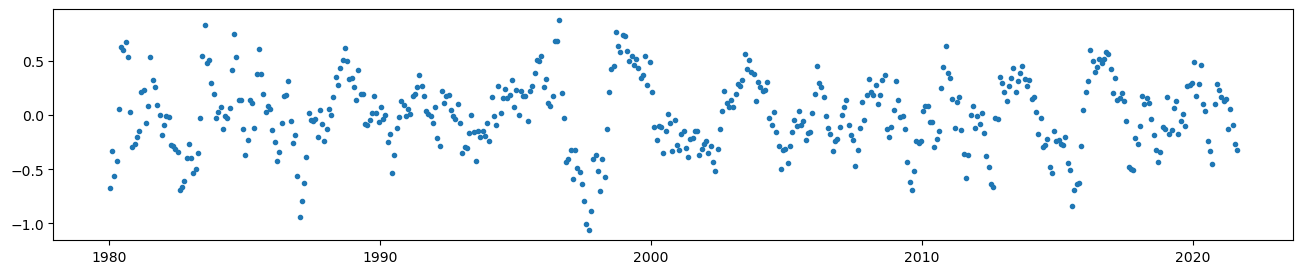

In [29]:
## plot final residuals
final_residuals = y_train - y
plt.figure(figsize=(16,3))
plt.scatter(x_train, final_residuals, marker=".")
plt.show()

In [30]:
torch.mean(final_residuals[0]).item()

-0.000307081431399638

In [31]:
torch.var(final_residuals[0]).item()

0.11096593968824846

In [32]:
# Q2e

<>:45: SyntaxWarning: invalid escape sequence '\p'
<>:45: SyntaxWarning: invalid escape sequence '\p'
/var/folders/7q/g76vv1gn7qs4j7dfwj8sqpyh0000gn/T/ipykernel_43543/1207254899.py:45: SyntaxWarning: invalid escape sequence '\p'
  plt.fill_between(x_test, final_preds_minus_sd, final_preds_plus_sd, color='gray', alpha=0.3, label="$\pm 1 \sigma$ Confidence")
/var/folders/7q/g76vv1gn7qs4j7dfwj8sqpyh0000gn/T/ipykernel_43543/1207254899.py:36: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y_test_total_co2 = y_test_true + linear_preds


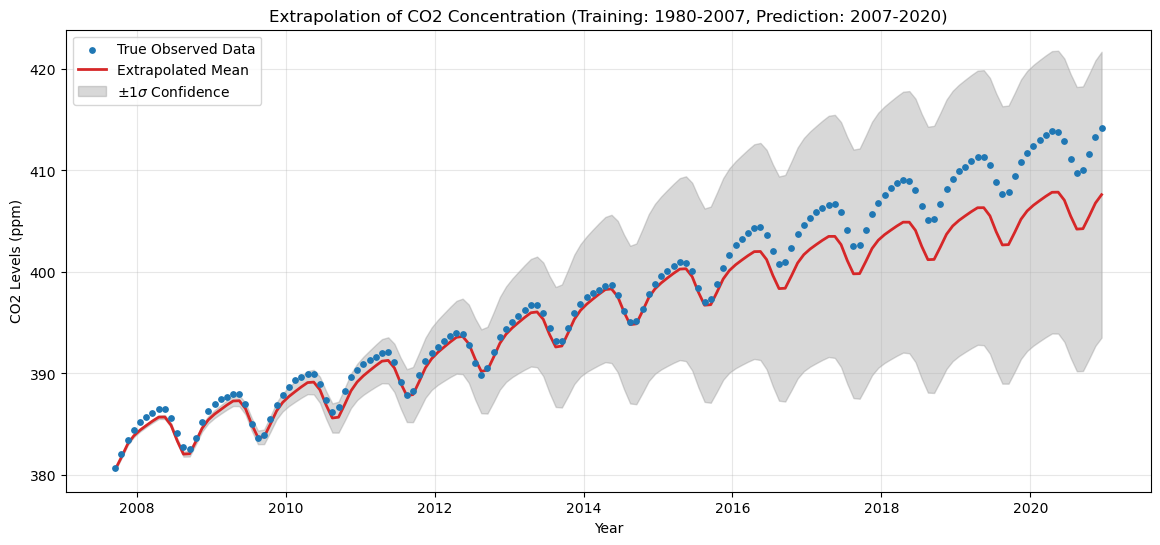

In [33]:
# --- 1. PREPARE THE DATA SPLIT ---
split_year = 2007
split_month = 9
data_start_year = 1980
split_idx = int(12 * (split_year - data_start_year) + split_month - 1)

# Full dataset
X_full = X[0, :]
Y_full = torch.tensor(residuals).flatten() 

# Create TRAINING set (1980 -> Aug 2007)
x_train = X_full[:split_idx]
y_train = Y_full[:split_idx]

# Create TEST set (Sep 2007 -> Dec 2020)
test_end_year = 2020
test_end_idx = int(12 * (test_end_year - data_start_year) + 12)
x_test = X_full[split_idx:test_end_idx]
y_test_true = Y_full[split_idx:test_end_idx]

# --- 2. RUN GP POSTERIOR ---
f = gp_posterior(x_train, y_train, x_test, theta=4.0, tau=1.0, sigma=2.0, phi=3.5, eta=5.0, zeta=0.1) # 

# --- 3. COMBINE WITH LINEAR MODEL ---
linear_preds = a_map * (x_test) + b_map

# Add GP residual predictions to the linear trend
final_preds_mean = torch.tensor(linear_preds) + f.loc
final_preds_plus_sd = final_preds_mean + f.stddev
final_preds_minus_sd = final_preds_mean - f.stddev

# --- 4. PLOTTING ---
plt.figure(figsize=(14, 6))

# 1. Reconstruct the Total CO2 (Residuals + Linear Trend)
y_test_total_co2 = y_test_true + linear_preds

# 2. Plot the Actuals
plt.scatter(x_test, y_test_total_co2, s=15, color='tab:blue', label="True Observed Data", zorder=3)

# 3. Plot the Mean Prediction
plt.plot(x_test, final_preds_mean, color='tab:red', linewidth=2, label="Extrapolated Mean")

# 4. Plot the Uncertainty
plt.fill_between(x_test, final_preds_minus_sd, final_preds_plus_sd, color='gray', alpha=0.3, label="$\pm 1 \sigma$ Confidence")

plt.legend(loc='upper left')
plt.title("Extrapolation of CO2 Concentration (Training: 1980-2007, Prediction: 2007-2020)")
plt.xlabel("Year")
plt.ylabel("CO2 Levels (ppm)")
plt.grid(True, alpha=0.3)
plt.show()